# Packages


In [197]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import joblib

from warnings import simplefilter

simplefilter(action="ignore")

In [198]:
random_state = 2023

# EDA

We have 35311 rows that correspond to 35311 items with unique IDs.


In [199]:
df = pd.read_csv("../data/pricerunner_aggregate.csv")
df = df.rename(columns=lambda x: x.strip())

In [200]:
df.head()

,Product ID,Product Title,Merchant ID,Cluster ID,Cluster Label,Category ID,Category Label
0,1,apple iphone 8 plus 64gb silver,1,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
1,2,apple iphone 8 plus 64 gb spacegrau,2,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
2,3,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,3,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
3,4,apple iphone 8 plus 64gb space grey,4,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
4,5,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,5,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones


In [201]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35311 entries, 0 to 35310
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Product ID      35311 non-null  int64 
 1   Product Title   35311 non-null  object
 2   Merchant ID     35311 non-null  int64 
 3   Cluster ID      35311 non-null  int64 
 4   Cluster Label   35311 non-null  object
 5   Category ID     35311 non-null  int64 
 6   Category Label  35311 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.9+ MB


In [202]:
df.describe(include="all")

,Product ID,Product Title,Merchant ID,Cluster ID,Cluster Label,Category ID,Category Label
count,35311.000000,35311,35311.000000,35311.000000,35311,35311.000000,35311
unique,NaN,30993,NaN,NaN,12849,NaN,10
top,NaN,washing machine,NaN,NaN,Canon IXUS 185,NaN,Fridge Freezers
freq,NaN,90,NaN,NaN,27,NaN,5501
mean,26150.800176,NaN,120.501883,30110.687633,NaN,2618.142930,NaN
std,13498.191220,NaN,117.045557,18410.265642,NaN,3.600708,NaN
min,1.000000,NaN,1.000000,1.000000,NaN,2612.000000,NaN
25%,14958.500000,NaN,17.000000,6123.000000,NaN,2615.000000,NaN
50%,27614.000000,NaN,75.000000,40630.000000,NaN,2619.000000,NaN
75%,37508.500000,NaN,253.000000,44059.000000,NaN,2622.000000,NaN


### Missing Values

There are no missing values in the dataset.


In [203]:
df.isnull().sum()

Product ID        0
Product Title     0
Merchant ID       0
Cluster ID        0
Cluster Label     0
Category ID       0
Category Label    0
dtype: int64

### Target Variable

We have 10 categories that correspond to 10 different IDs.


In [204]:
unique_pairs = df[["Category Label", "Category ID"]].drop_duplicates()
unique_pairs.reset_index(drop=True, inplace=True)
unique_pairs

,Category Label,Category ID
0,Mobile Phones,2612
1,TVs,2614
2,CPUs,2615
3,Digital Cameras,2617
4,Microwaves,2618
5,Dishwashers,2619
6,Washing Machines,2620
7,Freezers,2621
8,Fridge Freezers,2622
9,Fridges,2623


## Class balance

On the graph, we see an imbalance of classes, so we will use the f1 metric for evaluation.


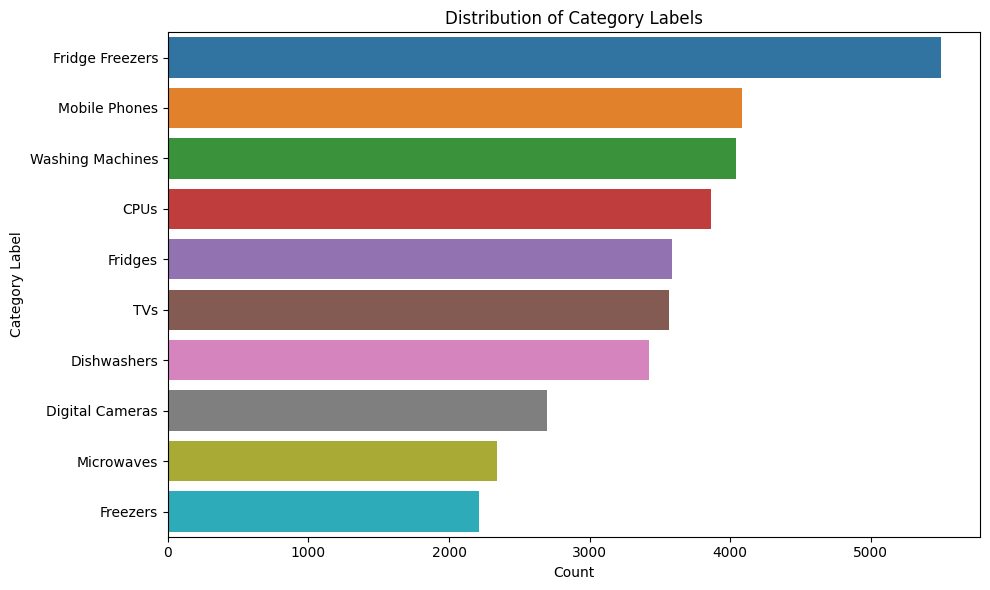

In [205]:
plt.figure(figsize=(10, 6))
sns.countplot(
    y="Category Label", data=df, order=df["Category Label"].value_counts().index
)
plt.title("Distribution of Category Labels")
plt.xlabel("Count")
plt.ylabel("Category Label")
plt.tight_layout()

## Models

Based on the "Merchant ID" and "Cluster ID", we predict the "Category ID".


In [206]:
X = df[["Merchant ID", "Cluster ID"]]
y = df["Category ID"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state
)

In [207]:
best_models = []

models = {
    "SGDClassifier": SGDClassifier(random_state=random_state),
    "LogisticRegression": LogisticRegression(random_state=random_state),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=random_state),
    "RandomForestClassifier": RandomForestClassifier(random_state=random_state),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=random_state),
}

parameters_grids = {
    "SGDClassifier": {
        "loss": ["hinge", "log"],
        "penalty": ["l2", "l1", "elasticnet"],
        "alpha": [0.0001, 0.001],
        "max_iter": [1000],
        "tol": [1e-3],
        "learning_rate": ["constant", "optimal"],
        "eta0": [0.001],
    },
    "LogisticRegression": {
        "penalty": ["l1", "l2"],
        "C": [1, 10],
        "solver": ["liblinear", "saga"],
    },
    "DecisionTreeClassifier": {
        "max_depth": [5, 10],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
        "max_features": ["sqrt", "log2"],
        "criterion": ["gini", "entropy"],
    },
    "RandomForestClassifier": {
        "n_estimators": [100, 200],
        "max_depth": [5, 10],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
        "max_features": ["sqrt", "log2"],
        "bootstrap": [True, False],
        "criterion": ["gini", "entropy"],
    },
    "GradientBoostingClassifier": {
        "learning_rate": [0.01, 0.1],
        "n_estimators": [100, 200],
        "max_depth": [3, 5],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
        "max_features": ["sqrt", "log2"],
    },
}

In [208]:
scorer = make_scorer(f1_score, average="weighted")

for model_name in models:
    print(f"Training {model_name}...")
    search = GridSearchCV(
        models[model_name],
        parameters_grids[model_name],
        cv=5,
        scoring=scorer,
        verbose=2,
        n_jobs=-1,
    )
    search.fit(X_train, y_train)
    best_models.append((model_name, search.best_score_, search.best_estimator_))

In [209]:
best_models = sorted(best_models, key=lambda x: x[1], reverse=True)[:3]

## Best Models
Train the top 3 on the entire dataset and save them.


In [210]:
for i, (model_name, score, model) in enumerate(best_models):
    print(f"Model {i+1}: {model_name} with F1-score: {score}")
    print("Best Parameters:", model.get_params())
    model.fit(X, y)
    joblib.dump(model, f"../models/{model_name}_best_model.pkl")

Model 1: GradientBoostingClassifier with F1-score: 0.9998938018671477
Best Parameters: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.01, 'loss': 'log_loss', 'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 2023, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Model 2: RandomForestClassifier with F1-score: 0.999822985561814
Best Parameters: {'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 2023, 'verbose': 0, 'warm_start': 